In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pysindy as ps

# **EQUATION  CONFIGURATION**

In [27]:
#Equation parameters 

# Parámetros basados en tu ecuación
omega_0 = 5.0      # Natural frequency (rad/s)
omega_f = 7.0      # Force frequency (rad/s)
V0_L = 10.0        # Force Amplitude (V0 / L) 



#System function
def forced_lc_system(t, y, u_func):
    Q = y[0]
    I = y[1]
    
    #Forcing singnal at time t
    forcing = u_func(t)
    
    dQ_dt = I
    dI_dt = -(omega_0**2) * Q + forcing
    
    return [dQ_dt, dI_dt]


#Force frecuency
def forcing_signal(t):
    return V0_L * np.cos(omega_f * t)


# **DATA GENERATION**

In [ ]:
dt = 0.01
t_train = np.arange(0, 10, dt)
initial_conditions = [2.0, 0.0]  # Q Initial=2, I Initial=0

# Solve the system to generate training data
sol = solve_ivp(
    fun=lambda t, y: forced_lc_system(t, y, forcing_signal),
    t_span=[t_train[0], t_train[-1]],
    y0=initial_conditions,
    t_eval=t_train
)

X_train = sol.y.T  # State matrix [n_samples, 2]

# Create the control input vector u(t) for SINDy
U_train = forcing_signal(t_train).reshape(-1, 1) 

print(f"Data generated: {X_train.shape} samples.")


Data generated: (1000, 2) samples.


# **SINDy TRAINING**

In [29]:

#Define equation library (linear terms only)
poly_library = ps.PolynomialLibrary(degree=1, include_bias=False)

#Optimize (Sequential Thresholded Least Squares)
optimizer = ps.STLSQ(threshold=0.1)

model = ps.SINDy(
    feature_library=poly_library,
    optimizer=optimizer,
    #feature_names=["Q", "I", "Forcing"] # Nombres para que la salida sea legible
)

# Train the model. 
# U= Force input
model.fit(x=X_train, t=dt, u=U_train)





,optimizer,STLSQ()
,feature_library,PolynomialLib...de_bias=False)
,differentiation_method,FiniteDifference()
,discrete_time,False
,degree,1
,include_interaction,True
,interaction_only,False
,include_bias,False
,order,'C'
,threshold,0.1
,alpha,0.05


# **MODEL RESULTS**

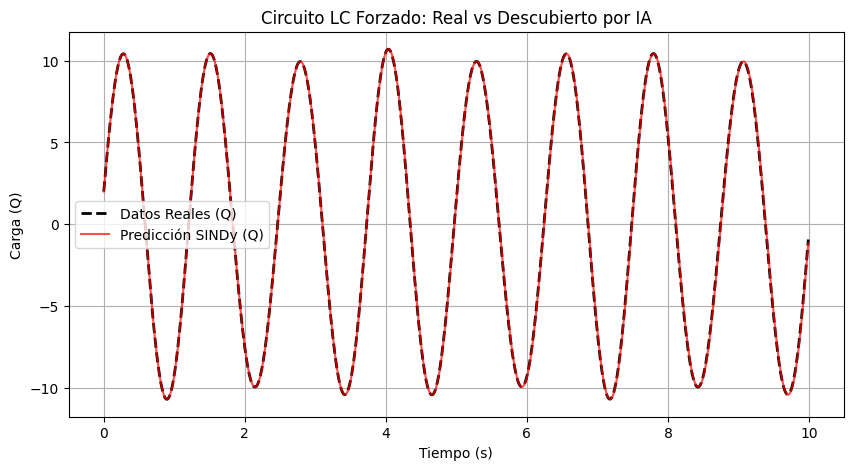

In [30]:

#Simulate the model with the initial conditions and forcing signal
X_sim = model.simulate(initial_conditions, t_train, u=forcing_signal)


#GRAPHICS
plt.figure(figsize=(10, 5))
plt.plot(t_train, X_train[:, 0], 'k--', label='Datos Reales (Q)', linewidth=2)
plt.plot(t_train, X_sim[:, 0], 'r', label='Predicción SINDy (Q)', alpha=0.7)
plt.title(f'Circuito LC Forzado: Real vs Descubierto por IA')
plt.xlabel('Tiempo (s)')
plt.ylabel('Carga (Q)')
plt.legend()
plt.grid(True)
plt.show()